In [1]:
import torch
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys

sys.path.append(Path('./').resolve().parent.__str__())

In [2]:
def convert_format(state_dict):
    return {
        'coeff': np.stack([
            val.cpu().numpy()
            for key, val in state_dict.items()
            if 'sadcl_coeff' in key
        ]),
        'linears': np.stack([
            val.cpu().numpy()
            for key, val in state_dict.items()
            if 'sadcl_embs_diff' in key
        ]),
        'origs': np.stack([
            val.cpu().numpy()
            for key, val in state_dict.items()
            if 'pretrained_embs' in key
        ]),
    }

In [29]:
from _mydelta.multi_prompt import MultiPrompt


def read_prompts(model_size):
    tasks = {
        'glue-qqp': 'QQP',
        'glue-qnli': 'QNLI',
        'glue-mnli': 'MNLI',
        'glue-sst2': 'SST-2',
        'glue-stsb': 'STS-B',
        'glue-mrpc': 'MRPC',
        'glue-cola': 'CoLA',
        'superglue-multirc': 'MultiRC',
        'superglue-rte': 'RTE',
        'superglue-cb': 'CB',
        'superglue-copa': 'COPA',
        'superglue-wic': 'WiC',
        'superglue-boolq': 'BoolQ'
    }

    tasks_prompts = {}

    for task_name, good_taskname in tasks.items():
        pretrained_path = Path(f'/disks/ssd/hzi_trained/hzi_cluster_t5_{model_size}_{task_name}/10_combine_128')
        weight_path = pretrained_path / 'best.pt'

        final_prompt = MultiPrompt.get_saved_final_emb(
            config_path=pretrained_path / 'config.json',
            weights_path=weight_path
        ).numpy()
        combined_info = convert_format(torch.load(weight_path))
        tasks_prompts[good_taskname] = {
            **combined_info,
            'final': final_prompt
        }
    return tasks_prompts

In [ ]:
import matplotlib as mpl

tasks_prompts = read_prompts('base')
all_coeff = np.stack([all_info['coeff'] for all_info in tasks_prompts.values()])
all_coeff_norm = all_coeff / np.linalg.norm(all_coeff, axis=2, keepdims=True)

plt.rcParams.update({"text.usetex": True, "font.family": "Times New Roman", "font.weight": "bold"})

for idx in range(10):
    token = all_coeff_norm[:, idx, :]

    tasks_map_list = list(tasks_prompts.keys())

    current_ax = sns.clustermap(token @ token.T, cmap="bwr_r", vmin=-1)
    old_ticks = current_ax.ax_heatmap.get_xticklabels()
    new_ticks = [tasks_map_list[int(tick.get_text())] for tick in old_ticks]
    current_ax.ax_heatmap.set_xticklabels(new_ticks, fontsize=45, rotation=90)
    current_ax.ax_heatmap.set_yticklabels(new_ticks, fontsize=45, ha='left', rotation=0)
    current_ax.ax_cbar.set_yticklabels([], fontsize=35)
    current_ax.savefig(f'{idx}.png')

In [26]:
import PIL

def concat_images(images):
    w, h = images[0].size
    height = h
    total_width = len(images) * w
        
    return_value = PIL.Image.new('RGB', (total_width, height))
    
    total_width = 0
    for image in images:
        w, h = image.size
        return_value.paste(image, (total_width, 0))
        total_width += w
    
    return return_value

row1 = concat_images([PIL.Image.open(f'{idx}.png') for idx in range(5)])
row2 = concat_images([PIL.Image.open(f'{idx}.png') for idx in range(5, 10)])

In [27]:
row1.save('row1.png')
row2.save('row2.png')

[Text(1, 0.5, 'CoLA'),
 Text(1, 1.5, 'QQP'),
 Text(1, 2.5, 'WiC'),
 Text(1, 3.5, 'MRPC'),
 Text(1, 4.5, 'MultiRC'),
 Text(1, 5.5, 'STS-B'),
 Text(1, 6.5, 'BoolQ'),
 Text(1, 7.5, 'CB'),
 Text(1, 8.5, 'COPA'),
 Text(1, 9.5, 'QNLI'),
 Text(1, 10.5, 'RTE'),
 Text(1, 11.5, 'MNLI'),
 Text(1, 12.5, 'SST-2')]

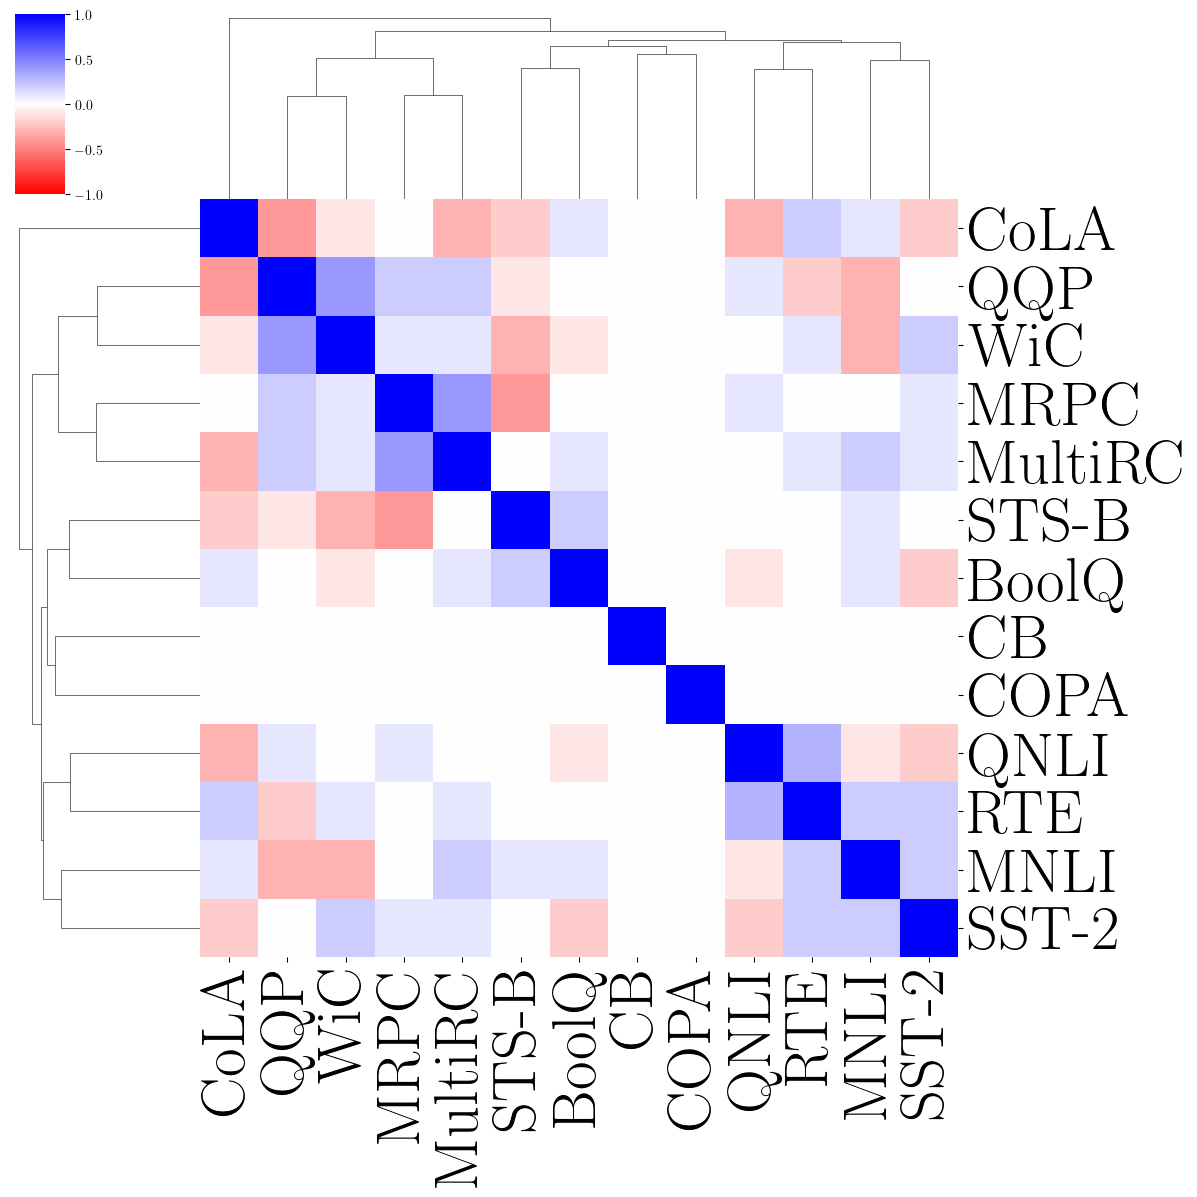

In [35]:
all_coeff_norm = all_coeff / np.linalg.norm(all_coeff, axis=2, keepdims=True)

def thresholding(mat, thr=0.4):
    positives = mat > thr
    negatives = mat < -thr
    return np.ones_like(mat) * positives - np.ones_like(mat) * negatives

res = sum(thresholding(all_coeff_norm[:, idx, :] @ all_coeff_norm[:, idx, :].T) for idx in range(10)) / 10
current_ax = sns.clustermap(res, cmap="bwr_r", vmin=-1)

old_ticks = current_ax.ax_heatmap.get_xticklabels()
new_ticks = [tasks_map_list[int(tick.get_text())] for tick in old_ticks]
current_ax.ax_heatmap.set_xticklabels(new_ticks, fontsize=45, rotation=90)
current_ax.ax_heatmap.set_yticklabels(new_ticks, fontsize=45, ha='left', rotation=0)

In [159]:
# feat = all_coeff.transpose([2, 0, 1])
# print(feat.shape)
# feat = feat.reshape([feat.shape[0], -1])
# print(feat.shape)
# feat = feat.T
# print(feat.shape)
# feat_norm = StandardScaler().fit_transform(feat)
# print(feat_norm.shape)
# feat_norm = feat_norm.T
# print(feat_norm.shape)
# feat_norm = feat_norm.reshape([128, 13, 10])
# print(feat_norm.shape)
# feat_norm = feat_norm.transpose([2, 1, 0])
# print(feat_norm.shape)

feat = np.stack([all_info['final'] for all_info in tasks_prompts.values()]).transpose([1, 0, 2])
feat.shape

(10, 13, 768)

In [172]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

embedding = TSNE(n_components=2, perplexity=2).fit_transform(feat[5])
embedding.shape

(13, 2)

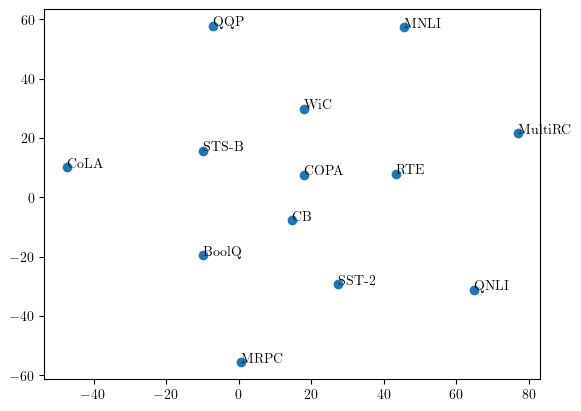

In [173]:
import matplotlib.pyplot as plt

tasks = {
    'glue-qqp': 'QQP',
    'glue-qnli': 'QNLI',
    'glue-mnli': 'MNLI',
    'glue-sst2': 'SST-2',
    'glue-stsb': 'STS-B',
    'glue-mrpc': 'MRPC',
    'glue-cola': 'CoLA',
    'superglue-multirc': 'MultiRC',
    'superglue-rte': 'RTE',
    'superglue-cb': 'CB',
    'superglue-copa': 'COPA',
    'superglue-wic': 'WiC',
    'superglue-boolq': 'BoolQ'
}

fig, ax = plt.subplots()

ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
)
# plt.gca().set_aspect('equal', 'datalim')
for i, txt in enumerate(tasks.values()):
    ax.annotate(txt, (embedding[i, 0], embedding[i, 1]))

In [17]:
token_ids = [mapper[token] for token in np.argmax(token_weights, axis=1)]

In [20]:
tokenizer1.decode(token_ids)

'appelstitution Come qualifistitutionviz volleyball Dortmundhéropathie'

In [ ]:
token = all_coeff_norm[:, 5, :]
sns.heatmap(np.abs(token @ token.T), cmap="Blues", )

<Axes: >

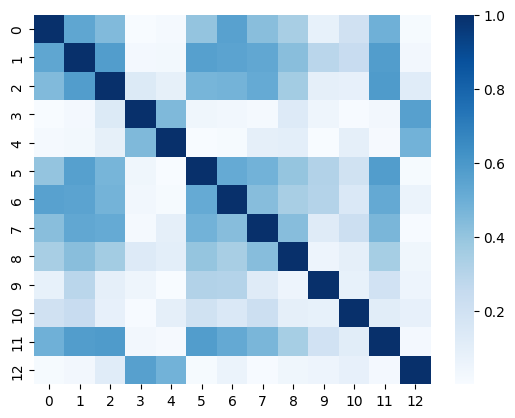

In [48]:
token = all_coeff_norm[:, 5, :]
sns.heatmap(np.abs(token @ token.T), cmap="Blues")

In [34]:
final_prompt_norm = final_prompt / np.linalg.norm(final_prompt, ord=2, keepdims=True, axis=1)
source_prompts_norm = source_prompts / np.linalg.norm(source_prompts, ord=2, keepdims=True, axis=1)


KeyboardInterrupt



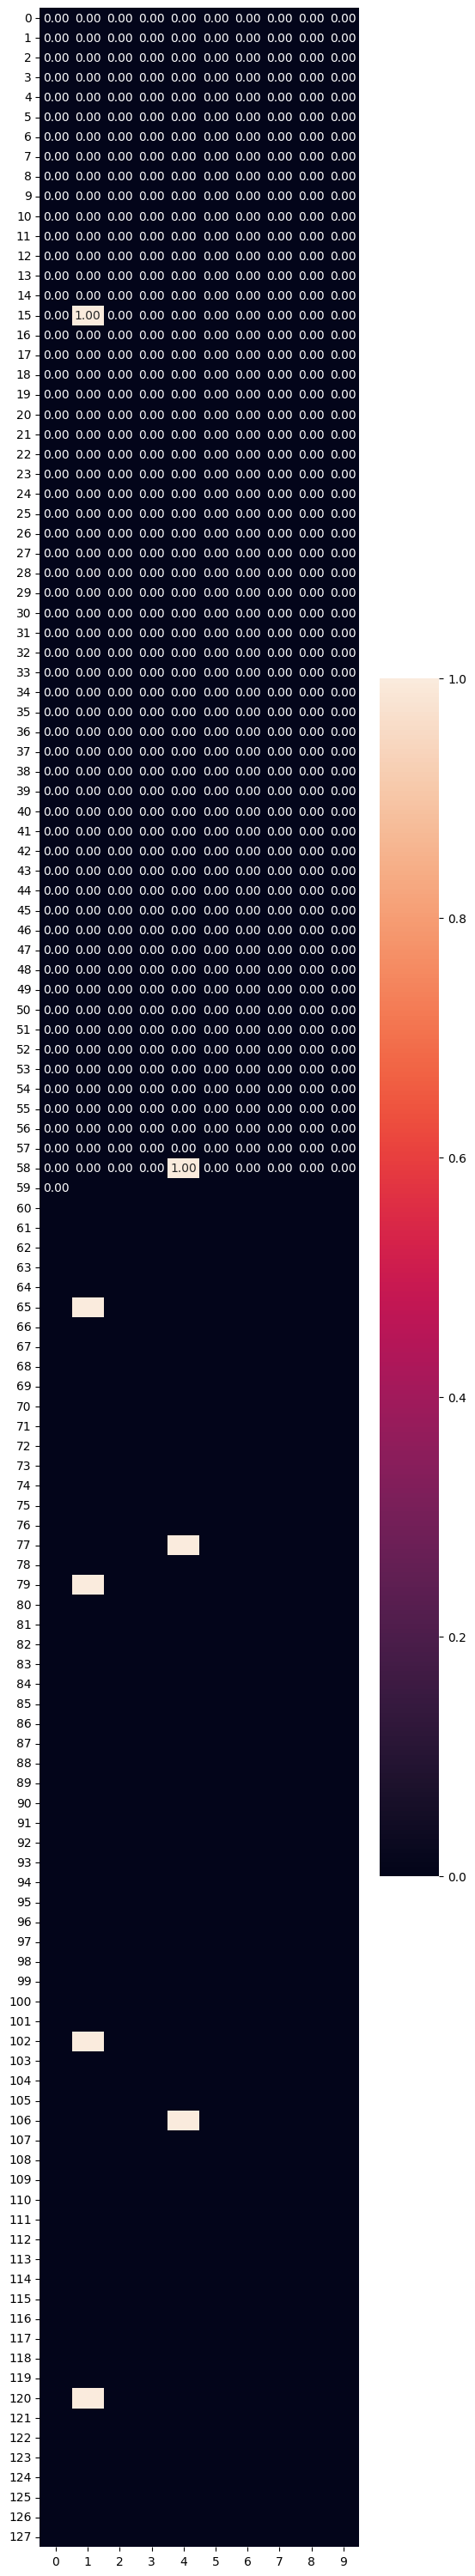

In [45]:
def heatmap(w, use_abs=False):
    if use_abs:
        w = np.abs(w)
        
    plt.figure(figsize = (6, 0.3 * w.shape[0]))
    sns.heatmap(w, annot=True, fmt='.2f')

heatmap(source_prompts_norm @ final_prompt_norm.T > 0.2)

In [15]:
source_prompts.shape

(128, 768)

In [ ]:
heatmap(np.linalg.norm(best['linears'], ord=2, axis=2).T)

In [ ]:
heatmap(np.linalg.norm(best['origs'] + best['linears'], ord=2, axis=2).T)

In [ ]:
np.linalg.norm(best['linears'][0][0])

In [ ]:
best['origs'].shape

In [ ]:
np.linalg.norm(best['origs'][0, 83])

In [ ]:
sns.histplot(best['coeff'].ravel())

In [ ]:
mat_diffs(first, last)

In [ ]:
plot_dist_embeding(torch.load(str(generate_path('large', 20))))

In [ ]:
w = torch.load(str(generate_path('large', 20)))['sadcl_learned_embedding'].cpu().numpy()
plt.figure(figsize = (32,5))
sns.heatmap(w.T, annot=True)

In [ ]:
w = torch.load(str(generate_path('base', 20)))['sadcl_learned_embedding'].cpu().numpy()
plt.figure(figsize = (32,5))
sns.heatmap(w.T, annot=True)

In [ ]:
import numpy as np
from transformers import T5ForConditionalGeneration, T5TokenizerFast

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# ______________________LOAD MODEL_____________________________

model = T5ForConditionalGeneration.from_pretrained('google/t5-small-lm-adapt')
tokenizer = T5TokenizerFast.from_pretrained('google/t5-small-lm-adapt', model_max_length=2048)
# ______________________MUTATE MODEL_____________________________
slected_tokens = torch.from_numpy(
    np.random.choice(
        tokenizer.vocab_size,
        size=(128,),
        replace=False)
)
slected_tokens[83]

In [ ]:
tokenizer.decode(32099)

In [ ]:
all_special = ''
for key, val in tokenizer.special_tokens_map.items():
    if isinstance(val, str):
        all_special += val
    else:
        all_special += ''.join(val)
tokens = tokenizer(all_special, add_special_tokens=False)

In [ ]:
sp_tokens = [1, 2, 0, 32099, 32098, 32097, 32096, 32095, 32094, 32093, 32092, 32091, 32090, 32089, 32088, 32087, 32086, 32085, 32084, 32083, 32082, 32081, 32080, 32079, 32078, 32077, 32076, 32075, 32074, 32073, 32072, 32071, 32070, 32069, 32068, 32067, 32066, 32065, 32064, 32063, 32062, 32061, 32060, 32059, 32058, 32057, 32056, 32055, 32054, 32053, 32052, 32051, 32050, 32049, 32048, 32047, 32046, 32045, 32044, 32043, 32042, 32041, 32040, 32039, 32038, 32037, 32036, 32035, 32034, 32033, 32032, 32031, 32030, 32029, 32028, 32027, 32026, 32025, 32024, 32023, 32022, 32021, 32020, 32019, 32018, 32017, 32016, 32015, 32014, 32013, 32012, 32011, 32010, 32009, 32008, 32007, 32006, 32005, 32004, 32003, 32002, 32001, 32000]

In [ ]:
len(sp_tokens)

In [ ]:
tokenizer.special_tokens_map
special_text = '</s><unk><pad><extra_id_0><extra_id_10><extra_id_20>'
tokenizer(special_text, add_special_tokens=False).input_ids

In [ ]:
eid = lambda x: f'<extra_id_{x}>'
all_eids = [eid(idx) for idx in range(0, 100)]
eid_all = ''.join(all_eids)
eid_ids = tokenizer(eid_all, add_special_tokens=False, return_tensors='pt').input_ids

In [ ]:
tokenizer.vocab_size

In [ ]:
0. == 0

In [ ]:
eid_ids

In [ ]:
embs = model.get_encoder().get_input_embeddings()(eid_ids)[0]
for str_tok, norm2 in zip(all_eids, np.linalg.norm(embs.detach().numpy(), axis=1)):
    print(str_tok, "%.2f" % norm2)

In [ ]:
torch.nn.functional.normalize(torch.Tensor([[3, 4], [5, 12]]), dim=0)

In [ ]:
torch.Tensor([[3, 4], [5, 12]])[:, 0]

In [ ]:
3 / 34 ** 0.5

In [ ]:
f = lambda n: f"""- <<: *default
  model_name: google/t5-base-lm-adapt
  wandb_name: base_5_{n}
  peft_params:
    kind: comb_prompt
    n_tokens: 5
    n_comb_tokens: {n}
    with_relu: False
    with_softmax: False
    keep_random: False
- <<: *default
  model_name: google/t5-base-lm-adapt
  wandb_name: base_5_{n}_random
  peft_params:
    kind: comb_prompt
    n_tokens: 5
    n_comb_tokens: {n}
    with_relu: False
    with_softmax: False
    keep_random: True"""
print('\n'.join(f(n) for n in [16, 32, 64, 128, 256]))

In [ ]:
torch.nn.functional.gumbel_softmax(torch.tensor([10., 100.]), hard=True)

In [ ]:
torch.norm(torch.Tensor([3, 3]))

In [ ]:
torch.zeros(1) + 3

In [ ]:
from transformers import T5TokenizerFast, T5Model

tokenizer = T5TokenizerFast.from_pretrained('google/t5-large-lm-adapt', model_max_length=2048)

In [ ]:
m = T5Model.from_pretrained('google/t5-large-lm-adapt')

In [ ]:
m.name_or_path

In [ ]:
tokenizer("hi: hi").tokens()

In [ ]:
tokenizer.sep_token

In [49]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [62]:
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model.generate(**encoded_input, max_new_tokens=50)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [63]:
tokenizer.decode(output[0].tolist())

"Replace me by any text you'd like.\n\nI'm not sure if you're aware of this, but I'm not sure if you're aware of this, but I'm not sure if you're aware of this, but I'm not sure if you're aware of this, but"

In [59]:
model.ge

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.34.0",
  "use_cache": true,
  "vocab_size": 50257
}